In [1]:
import time
import numpy as np
import pickle
import awkward as ak
import dask_awkward as dak
from distributed import Client
from omegaconf import OmegaConf

from typing import Tuple, List, Dict
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.pyplot as plt
import matplotlib
plt.style.use(hep.style.CMS)

In [2]:
# ! ls /work/users/yun79/stage2_output/DNN_test2/ggh/2018/
! ls /work/users/yun79/stage2_output/DNN_test_WgtOn_includeQGL_AN_BDT_AllSigNBkg13Sept2024/ggh/2018/

processed_events_bkgMC_dy.parquet   processed_events_data.parquet
processed_events_bkgMC_ewk.parquet  processed_events_sigMC_ggh.parquet
processed_events_bkgMC_st.parquet   processed_events_sigMC_vbf.parquet
processed_events_bkgMC_tt.parquet


In [3]:
# load_path = f"/work/users/yun79/stage2_output/DNN_test2/ggh/2018/processed_events_bkgMC*.parquet"
# load_path = f"/work/users/yun79/stage2_output/DNN_test2/ggh/2018/processed_events_bkgMC_dy.parquet"
load_path = "/work/users/yun79/stage2_output/DNN_test_WgtOn_includeQGL_AN_BDT_AllSigNBkg13Sept2024/ggh/2018/processed_events_bkgMC*.parquet"
processed_events = ak.from_parquet(load_path)
region = processed_events.h_peak != 0
# DNN_score_raw is a sigmoid output
bkg = (ak.to_numpy(processed_events.BDT_score[region]))
bkg_wgt = (ak.to_numpy(processed_events.wgt_nominal_total[region]))
bkg_label = 0*np.ones_like(bkg)


# load_path = f"/work/users/yun79/stage2_output/DNN_test2/ggh/2018/processed_events_sigMC*.parquet"
# load_path = f"/work/users/yun79/stage2_output/DNN_test2/ggh/2018/processed_events_sigMC_vbf.parquet"
load_path = "/work/users/yun79/stage2_output/DNN_test_WgtOn_includeQGL_AN_BDT_AllSigNBkg13Sept2024/ggh/2018/processed_events_sigMC*.parquet"

processed_events = ak.from_parquet(load_path)
region = processed_events.h_peak != 0
sig = (ak.to_numpy(processed_events.BDT_score[region]))
sig_wgt = (ak.to_numpy(processed_events.wgt_nominal_total[region]))
sig_label = np.ones_like(sig)
print(np.min(bkg))
print(np.max(bkg))
print(np.min(sig))
print(np.max(sig))
print(bkg.shape)
print(sig.shape)
pred = np.concatenate((bkg,sig), axis=0)
wgt_total = np.concatenate((bkg_wgt,sig_wgt), axis=0)
label = np.concatenate((bkg_label,sig_label), axis=0)
print(pred.shape)
print(wgt_total.shape)
print(label.shape)

0.001705770380795002
0.9842202067375183
0.0016725551104173064
0.9780676960945129
(5674419,)
(1293839,)
(6968258,)
(6968258,)
(6968258,)


In [6]:
def customROC_curve_AN(label, pred, weight):
    """
    generates signal and background efficiency consistent with the AN,
    as described by Fig 4.6 of Dmitry's PhD thesis
    """
    # we assume sigmoid output with labels 0 = background, 1 = signal
    thresholds = np.linspace(start=0,stop=1, num=500) 
    effBkg_total = -99*np.ones_like(thresholds) # effBkg = false positive rate
    effSig_total = -99*np.ones_like(thresholds) # effSig = true positive rate
    for ix in range(len(thresholds)):
        threshold = thresholds[ix]
        # get FP and TP
        positive_filter = (pred > threshold)
        falsePositive_filter = positive_filter & (label == 0)
        FP = np.sum(weight[falsePositive_filter])#  FP = false positive
        truePositive_filter = positive_filter & (label == 1)
        TP = np.sum(weight[truePositive_filter])#  TP = true positive
        

        # get TN and FN
        negative_filter = (pred <= threshold) # just picked negative to be <=
        trueNegative_filter = negative_filter & (label == 0)
        TN = np.sum(weight[trueNegative_filter])#  TN = true negative
        falseNegative_filter = negative_filter & (label == 1)
        FN = np.sum(weight[falseNegative_filter])#  FN = false negative

        

        # effBkg = TN / (FN + TN)
        # effSig = TP / (TP + FP)
        # effBkg = TN / (FP + TN)
        # effSig = TP / (TP + FN)
        effBkg = TN / (TN + FP)
        effSig = FN / (FN + TP)
        effBkg_total[ix] = effBkg
        effSig_total[ix] = effSig

        # print(f"TN: {TN}")
        # print(f"FN: {FN}")
        
        # sanity check
        assert ((np.sum(positive_filter) + np.sum(negative_filter)) == len(pred))
        total_yield = FP + TP + FN + TN
        assert(np.isclose(total_yield, np.sum(weight)))
        # print(f"total_yield: {total_yield}")
        # print(f"np.sum(weight): {np.sum(weight)}")
    print(f"np.sum(effBkg_total ==-99) : {np.sum(effBkg_total ==-99)}")
    print(f"np.sum(effSig_total ==-99) : {np.sum(effSig_total ==-99)}")
    effBkg_total[np.isnan(effBkg_total)] = 1
    effSig_total[np.isnan(effSig_total)] = 1
    return (effBkg_total, effSig_total, thresholds)



np.sum(effBkg_total ==-99) : 0
np.sum(effSig_total ==-99) : 0


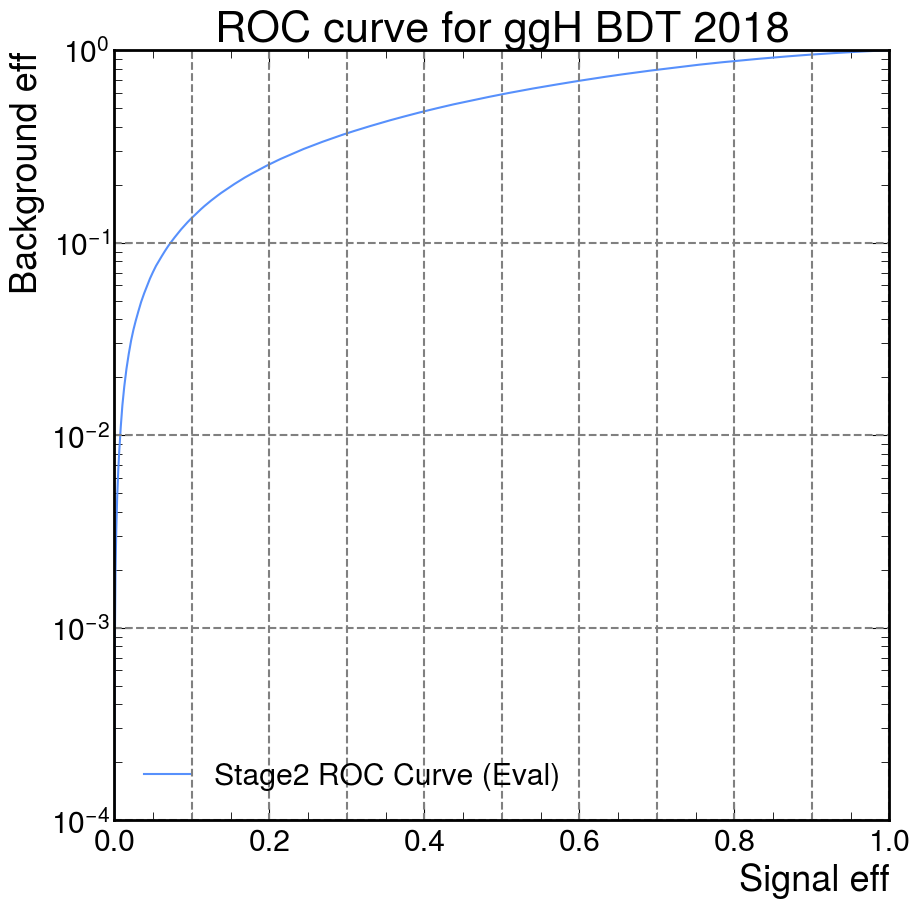

In [7]:
eff_bkg, eff_sig, thresholds = customROC_curve_AN(label, pred, wgt_total)
plt.figure()  
plt.plot(eff_sig, eff_bkg, label="Stage2 ROC Curve (Eval)")

# plt.vlines(eff_sig, 0, eff_bkg, linestyle="dashed")
plt.vlines(np.linspace(0,1,11), 0, 1, linestyle="dashed", color="grey")
plt.hlines(np.logspace(-4,0,5), 0, 1, linestyle="dashed", color="grey")
# plt.hlines(eff_bkg, 0, eff_sig, linestyle="dashed")
plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
plt.xlabel('Signal eff')
plt.yscale("log")
plt.ylim([0.0001, 1.0])
plt.ylabel('Background eff')
plt.title('ROC curve for ggH BDT 2018')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.show()

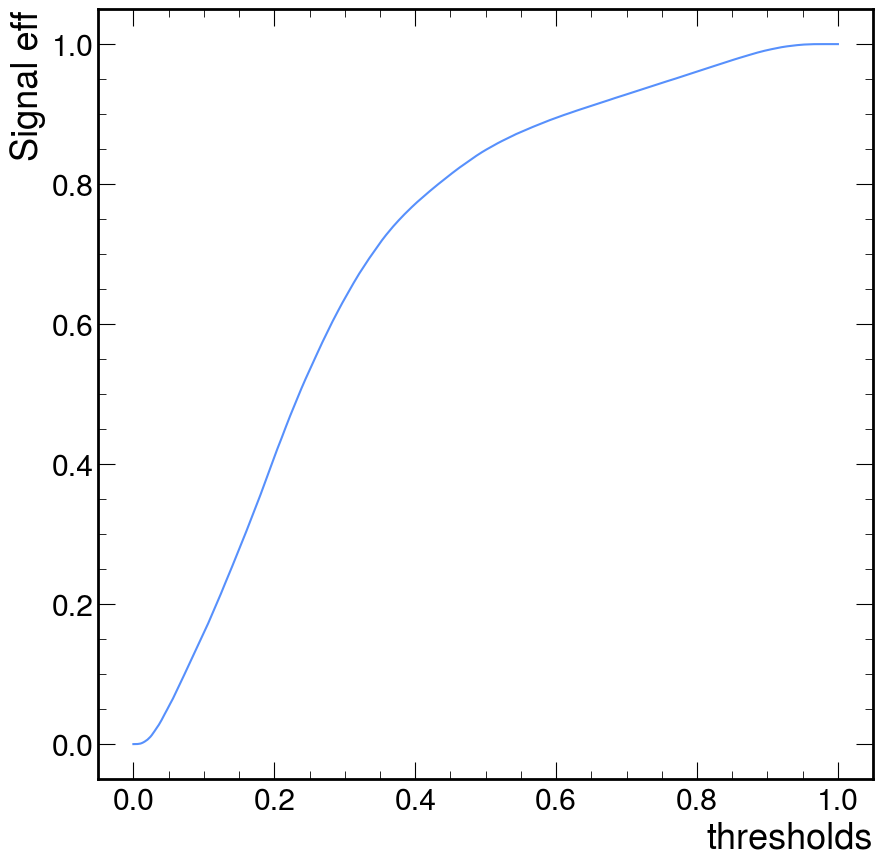

In [8]:
# plot to find the best threshold for signal efficiency
plt.figure()  
plt.plot(thresholds, eff_sig)
plt.ylabel('Signal eff')
plt.xlabel('thresholds')
plt.show()

In [17]:
def findBDT_binVals(thresholds, eff_sigs, sigEffBinEdges):
    """
    we expect len(sigEffBinEdges) == number of categories + 1,
    we expect sshape of thresholds == shape of eff_sigs
    """
    bin_vals = []
    for target_eff in sigEffBinEdges:
        print(f"target_eff: {target_eff}")
        for ix in range(len(eff_sigs)):
            # print(f"ix: {ix}")
            ith_sigEff = eff_sigs[ix]
            ith_thres = thresholds[ix]
            
            if target_eff <= ith_sigEff:
                print(f"ith_sigEff: {ith_sigEff}")
                print(f"ith_thres: {ith_thres}")
                bin_vals.append(ith_thres)
                break
        print(f"-----------------------------------------")
    return bin_vals
sigEffBinEdges = [0, 0.3, 0.65, 0.8, 0.95, 1.0] # Run2 edges
bin_vals = findBDT_binVals(thresholds, eff_sig, sigEffBinEdges)
print(bin_vals) # this is specifically for 2018, for other eras, please use BDTs trained in respective eras


target_eff: 0
ith_sigEff: 0.0
ith_thres: 0.0
-----------------------------------------
target_eff: 0.3
ith_sigEff: 0.3040373097199168
ith_thres: 0.16032064128256512
-----------------------------------------
target_eff: 0.65
ith_sigEff: 0.6517103381842849
ith_thres: 0.30861723446893785
-----------------------------------------
target_eff: 0.8
ith_sigEff: 0.8000677277079649
ith_thres: 0.43286573146292584
-----------------------------------------
target_eff: 0.95
ith_sigEff: 0.9500909389796874
ith_thres: 0.7675350701402806
-----------------------------------------
target_eff: 1.0
ith_sigEff: 1.0
ith_thres: 0.9799599198396792
-----------------------------------------
[0.0, 0.16032064128256512, 0.30861723446893785, 0.43286573146292584, 0.7675350701402806, 0.9799599198396792]
